In [186]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from OGMM import OGMM, init_cov_and_T_split
from sklearn.mixture import GaussianMixture
from scipy.special import logsumexp

from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
dataset = np.load('MGR.npy')
domain_names = ['Noiseless', "buccaneer2", "destroyerengine", "f16", "factory2"]

In [4]:
data_noiseless = dataset[:1000, :]
# feature column 17 is only zeros
data_noiseless = np.delete(data_noiseless, 17, axis=1)

# separation between training and validation data
data_noiseless = np.random.permutation(data_noiseless)
prop_train = 0.8
data_train = data_noiseless[:int(prop_train * len(data_noiseless)), :]
data_test = data_noiseless[int(prop_train * len(data_noiseless)):, :]


# Features of the noiseless data
X_train = data_train[:, :-2]
X_train_t = torch.from_numpy(X_train)
X_test = data_test[:, :-2]
X_test_t = torch.from_numpy(X_test)

# Labels of the noiseless data
y_train = data_train[:, -2]
y_test = data_test[:, -2]

## Log likelihood function

In [241]:
GMM_sklearn = GaussianMixture(n_components=10, random_state=0).fit(X_train)

In [242]:
np.sum(GMM_sklearn.score_samples(X_test))

-48604.62995748929

In [243]:
def normal_pdf(x, mean, cov, bib='numpy'):
    if bib == 'numpy':
        return (2*np.pi)**(-len(x)/2) * np.linalg.det(cov)**(-1/2) * np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean))
    else:
        return (2*torch.pi)**(-len(x)/2) * torch.linalg.det(cov)**(-1/2) * torch.exp(-1/2 * (x - mean).T @ torch.inverse(cov) @ (x - mean))

def log_normal_pdf(x, mean, cov, bib='numpy'):
    if bib == 'numpy':
        return -len(x)/2*np.log(2*np.pi) - 1/2*(np.log(np.linalg.det(cov)) + (x - mean).T @ np.linalg.inv(cov) @ (x - mean))
    else:
        return -len(x)/2*torch.log(torch.tensor(2*torch.pi)) - 1/2*(torch.log(torch.linalg.det(cov)) + (x - mean).T @ torch.inverse(cov) @ (x - mean))

In [244]:
def log_likelihood(mixture, X, bib='numpy'):
    log_pdf = np.zeros((X.shape[0], len(mixture)))
    for i in range(X.shape[0]):
        for j in range(len(mixture)):
            log_pdf[i, j] = np.log(mixture[j][0]) + log_normal_pdf(X[i], mixture[j][2], mixture[j][3], bib)
            
    return np.sum(logsumexp(log_pdf, axis=1))

In [245]:
means = GMM_sklearn.means_
weights = GMM_sklearn.weights_
cov = GMM_sklearn.covariances_
GMM_sklearn_list = [[weights[i], 1, means[i], cov[i]] for i in range(len(weights))]

In [246]:
ll_sklearn = log_likelihood(GMM_sklearn_list, X_test)
ll_sklearn

-48604.62995748904

In [247]:
range_data = np.mean(np.max(X_train, axis=0) - np.min(X_train, axis=0))

K_max = 10
cov_init, T_split = init_cov_and_T_split(K_max, range_data, X_train.shape[1])
GMM_online = OGMM(X_train_t, K_max, cov_init, 0.1, T_split)

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\linalg\linalg.py:2140: RuntimeWarning: overflow encountered in cast
  r = r.astype(result_t, copy=False)


KeyboardInterrupt: 

In [ ]:
GMM_online

[[tensor(0.1972),
  tensor(132.),
  tensor([ 3.7710e-01,  8.9506e-02,  1.4990e-01,  4.8999e-03,  2.2505e+03,
           7.7174e+05,  2.4603e+03,  2.3505e+05,  4.8723e+03,  3.2094e+06,
           9.0154e-02,  3.8775e-03, -4.7475e-04,  1.7263e-02, -5.6888e-04,
           6.6868e-03,  1.1966e+02, -1.3400e+02,  4.3884e+03,  9.4404e+01,
           1.0701e+03,  5.3889e+00,  5.4914e+02,  2.8903e+01,  2.7914e+02,
           7.3139e+00,  2.2797e+02,  1.0353e+01,  1.6806e+02,  1.9417e-01,
           1.4464e+02,  5.4422e+00,  1.0910e+02, -2.3530e+00,  1.0825e+02,
           4.7494e+00,  9.9989e+01, -4.2052e+00,  8.0615e+01,  6.7147e-01,
           7.1183e+01, -4.4381e+00,  7.0331e+01, -1.1898e-02,  6.5975e+01,
          -3.0180e+00,  6.6007e+01, -1.3799e+00,  7.0075e+01, -2.0602e+00,
           7.3649e+01, -7.4384e-01,  6.5961e+01, -1.1494e+00,  6.4027e+01,
          -1.6824e+00,  7.5786e+01], dtype=torch.float64),
  tensor([[ 6.4277e-03, -1.6144e-04,  7.9656e-04,  ..., -1.8153e+00,
            2

In [ ]:
ll_online = log_likelihood(GMM_online, X_test_t, 'torch')
ll_online

-168833.03952049155

In [ ]:
(ll_online - ll_sklearn)/ll_sklearn

2.1266674713964187

## PCA

In [212]:
data_features = data_noiseless[:, :-2]
data_labels = data_noiseless[:, -2]

In [213]:
def approximate_data(data_features, n_neighbors, n_components):
    NN = NearestNeighbors(n_neighbors=n_neighbors)
    NN.fit(data_features)

    _, indices = NN.kneighbors(data_features)
    NN_features = data_features[indices]


    pca = PCA(n_components=n_components)
    pca.whiten = False
    data_approx = np.zeros(data_features.shape)

    for i in range(NN_features.shape[0]):
        X_trans = pca.fit_transform(NN_features[i, :, :])
        X_app = pca.inverse_transform(X_trans)[0]
        data_approx[i] = X_app.reshape(-1,)
    
    return data_approx

In [214]:
def approx_classification_error(data_features, data_labels, data_approx):
    classifier = RandomForestClassifier(criterion = 'log_loss')
    X_train, X_test, y_train, y_test = train_test_split(data_features, data_labels, test_size=0.2, random_state=0)
    X_train_approx, X_test_approx, y_train_approx, y_test_approx = train_test_split(data_approx, data_labels, test_size=0.2, random_state=0)

    classifier.fit(X_train, y_train)

    approx_error_list = []
    for i in range(1):
        y_pred = classifier.predict(X_test)
        y_pred_approx = classifier.predict(X_test_approx)

        accuracy_raw = accuracy_score(y_test, y_pred)
        accuracy_approx = accuracy_score(y_test_approx, y_pred_approx)

        approx_error_list.append(np.abs((accuracy_approx - accuracy_raw))/accuracy_raw)

    return np.mean(approx_error_list)

In [215]:
approx_error = []
for i in range(3, 58, 3):
    print(i)
    data_approx = approximate_data(data_features, 57, i)
    approx_error.append(approx_classification_error(data_features, data_labels, data_approx))

3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57


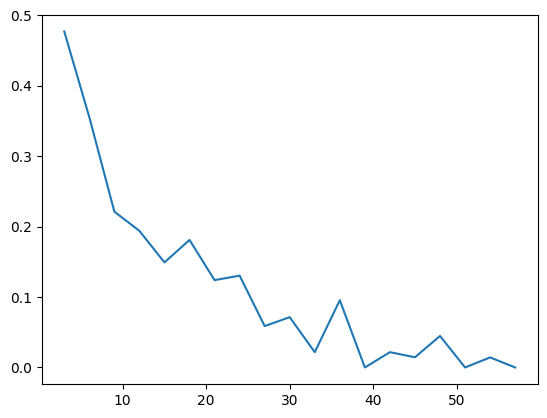

In [216]:
fig, ax = plt.subplots()
ax.plot(range(3, 58, 3), approx_error)